## Classifier:
This jupyter notebook allows to train a pre-trained model using *transfer learning* to classify images of celebrities.

available models:
    * Resnet152
    * Alexnet
    * VGG11_bn
    * Squeezenet
    * Densenet
    * Mobilenet v2

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create train and test dataset
split the dataset in train and test dataset using the class LFW

In [2]:
from src.lfw import LFW

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/storage/lfw"

lfw = LFW(data_dir, test_sample=0.2, limit_to_A=False)
lfw_limit = LFW(data_dir, test_sample=0.2, limit_to_A=True)

## Define the model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy


def set_parameter_requires_grad(mdl, feature_extracting):
    if feature_extracting:
        for param in mdl.parameters():
            param.requires_grad = False


class CNNFeatureExtraction:

    def __init__(self, data, model_name, num_classes, batch_size, num_epochs, feature_extract, topk=5):
        self.data = data
        self.model_name = model_name
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.feature_extract = feature_extract
        self.topk = topk
        self.model_ft, self.input_size = self.initialize_model()
        self.criterion, self.optimizer, self.params_to_update, self.dataloaders_dict = self.prepare_data()

    def get_model(self):
        return self.model_ft

    def set_model(self, model):
        self.model_ft = model

    def initialize_model(self, use_pretrained=True):
        # Initialize these variables which will be set in this if statement. Each of these
        #   variables is model specific.
        model_ft = None
        input_size = 0

        if self.model_name == "resnet":
            """ Resnet152
            """
            model_ft = models.resnet152(pretrained=use_pretrained)
            set_parameter_requires_grad(model_ft, self.feature_extract)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, self.num_classes)
            input_size = 224

        elif self.model_name == "alexnet":
            """ Alexnet
            """
            model_ft = models.alexnet(pretrained=use_pretrained)
            set_parameter_requires_grad(model_ft, self.feature_extract)
            num_ftrs = model_ft.classifier[6].in_features
            model_ft.classifier[6] = nn.Linear(num_ftrs, self.num_classes)
            input_size = 224

        elif self.model_name == "vgg":
            """ VGG11_bn
            """
            model_ft = models.vgg11_bn(pretrained=use_pretrained)
            set_parameter_requires_grad(model_ft, self.feature_extract)
            num_ftrs = model_ft.classifier[6].in_features
            model_ft.classifier[6] = nn.Linear(num_ftrs, self.num_classes)
            input_size = 224

        elif self.model_name == "squeezenet":
            """ Squeezenet
            """
            model_ft = models.squeezenet1_0(pretrained=use_pretrained)
            set_parameter_requires_grad(model_ft, self.feature_extract)
            model_ft.classifier[1] = nn.Conv2d(512, self.num_classes, kernel_size=(1, 1), stride=(1, 1))
            model_ft.num_classes = self.num_classes
            input_size = 224

        elif self.model_name == "densenet":
            """ Densenet
            """
            model_ft = models.densenet121(pretrained=use_pretrained)
            set_parameter_requires_grad(model_ft, self.feature_extract)
            num_ftrs = model_ft.classifier.in_features
            model_ft.classifier = nn.Linear(num_ftrs, self.num_classes)
            input_size = 224
            
        elif self.model_name == "mobilenetv2":
            """ mobilenet
            """
            model_ft = models.mobilenet_v2(pretrained=use_pretrained)
            set_parameter_requires_grad(model_ft, self.feature_extract)
            num_ftrs = model_ft.classifier[1].in_features
            model_ft.classifier[1] = nn.Linear(num_ftrs, self.num_classes)
            input_size = 224

        elif self.model_name == "inception":
            """ Inception v3
            Be careful, expects (299,299) sized images and has auxiliary output
            """
            model_ft = models.inception_v3(pretrained=use_pretrained)
            set_parameter_requires_grad(model_ft, self.feature_extract)
            # Handle the auxilary net
            num_ftrs = model_ft.AuxLogits.fc.in_features
            model_ft.AuxLogits.fc = nn.Linear(num_ftrs, self.num_classes)
            # Handle the primary net
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, self.num_classes)
            input_size = 299

        else:
            print("Invalid model name, exiting...")
            exit()

        return model_ft, input_size

    def prepare_data(self):

        print("Initializing Datasets and Dataloaders...")

        # Create training and validation dataloaders
        dataloaders_dict = {
                'train': torch.utils.data.DataLoader(self.data.train_data, batch_size=self.batch_size, shuffle=True),
                'test': torch.utils.data.DataLoader(self.data.test_data, batch_size=self.batch_size, shuffle=False)
        }

        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        params_to_update = self.model_ft.parameters()
        print("Params to learn:")
        if self.feature_extract:
            params_to_update = []
            for name, param in self.model_ft.named_parameters():
                if param.requires_grad:
                    params_to_update.append(param)
                    print("\t", name)
        else:
            for name, param in self.model_ft.named_parameters():
                if param.requires_grad:
                    print("\t", name)

        optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

        criterion = nn.CrossEntropyLoss()
        return criterion, optimizer_ft, params_to_update, dataloaders_dict

    def train_model(self, is_inception=False):
        # Detect if we have a GPU available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Send the model to GPU
        self.model_ft = self.model_ft.to(device)
        since = time.time()

        val_acc_history = []

        best_model_wts = copy.deepcopy(self.model_ft.state_dict())
        best_acc = 0.0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    self.model_ft.train()  # Set model to training mode
                else:
                    self.model_ft.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for step, (inputs, labels, attributes, true_images) in enumerate(self.dataloaders_dict[phase]):
                    if phase == 'train':
                        inputs = inputs.to(device)
                    else:
                        inputs = true_images.to(device)
                    labels = labels.to(device)
                    
                    

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        if is_inception and phase == 'train':
                            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                            outputs, aux_outputs = self.model_ft(inputs)
                            loss1 = self.criterion(outputs, labels)
                            loss2 = self.criterion(aux_outputs, labels)
                            loss = loss1 + 0.4 * loss2
                        else:
                            outputs = self.model_ft(inputs)
                            loss = self.criterion(outputs, labels)

                        #_, preds = torch.max(outputs, 1)
                        _, preds = torch.topk(outputs, k=self.topk, dim=1)
                        
                        
                        
                        if (step % 200 == 0):
                            if phase == 'train':
                                print('*' * 30) 
                                print('train')
                                print('*' * 30) 
                            elif phase == 'test':
                                print('*' * 30) 
                                print('test')
                                print('*' * 30)
                            image_pred1 = self.data.get_images(preds.data.cpu().numpy()[0][0])
                            image_pred2 = self.data.get_images(preds.data.cpu().numpy()[0][1])
                            print("target image")
                            self.data.plot_face(inputs[0].cpu(), labels.data.cpu().numpy()[0])
                            print("prediction representations")
                            self.data.plot_face(image_pred1, preds.data.cpu().numpy()[0][0])
                            self.data.plot_face(image_pred2, preds.data.cpu().numpy()[0][1])
                            print("step : ", step)
                            print("predictions : ", preds[:5])
                            print("labels : ", labels.data[:5])

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    #running_corrects += torch.sum(preds == labels.data)
                    #compute acc
                    running_batch_corrects = 0
                    for i in range(labels.size(0)):
                        running_batch_corrects += 1 if labels[i].item() in preds[i] else 0
                    running_corrects += running_batch_corrects

                epoch_loss = running_loss / len(self.dataloaders_dict[phase].dataset)
                epoch_acc = float(running_corrects) / len(self.dataloaders_dict[phase].dataset) * 100

                print('{} Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model_ft.state_dict())
                if phase == 'test':
                    val_acc_history.append(epoch_acc)

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        self.model_ft.load_state_dict(best_model_wts)
        return self.model_ft, val_acc_history

## Setup the model

In [8]:
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "mobilenetv2"

# Number of classes in the dataset
num_classes = 5749

# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

continueTraining = False

cnn_fe = CNNFeatureExtraction(data=lfw, model_name=model_name, num_classes=num_classes,
                              batch_size=batch_size, num_epochs=num_epochs, feature_extract=False, topk=5)

if continueTraining:
    model = cnn_fe.get_model()
    model.load_state_dict(torch.load("classify_mobilenetv2.model"))
    cnn_fe.set_model(model)

PyTorch Version:  1.4.0.dev20191119
Torchvision Version:  0.5.0.dev20191119
Initializing Datasets and Dataloaders...
Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.conv.0.0.weight
	 features.1.conv.0.1.weight
	 features.1.conv.0.1.bias
	 features.1.conv.1.weight
	 features.1.conv.2.weight
	 features.1.conv.2.bias
	 features.2.conv.0.0.weight
	 features.2.conv.0.1.weight
	 features.2.conv.0.1.bias
	 features.2.conv.1.0.weight
	 features.2.conv.1.1.weight
	 features.2.conv.1.1.bias
	 features.2.conv.2.weight
	 features.2.conv.3.weight
	 features.2.conv.3.bias
	 features.3.conv.0.0.weight
	 features.3.conv.0.1.weight
	 features.3.conv.0.1.bias
	 features.3.conv.1.0.weight
	 features.3.conv.1.1.weight
	 features.3.conv.1.1.bias
	 features.3.conv.2.weight
	 features.3.conv.3.weight
	 features.3.conv.3.bias
	 features.4.conv.0.0.weight
	 features.4.conv.0.1.weight
	 features.4.conv.0.1.bias
	 features.4.conv.1.0.weight
	 features.4.conv.1.1.weig

## Start and save the model

In [ ]:
model, hist = cnn_fe.train_model()
torch.save(model, "mobilenetv2_top5")

In [24]:
torch.save(model, "pred.model")

## Random visualization

true images


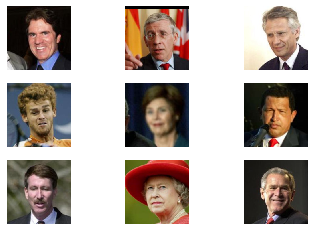

predicted class representatives


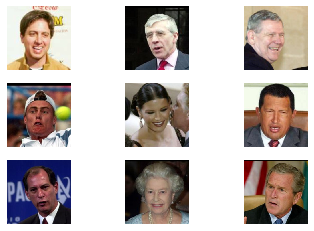

In [22]:
model = model.to(device)

indices = random.sample(range(len(lfw.test_data)), 9)

images = torch.stack([lfw.test_data[i][3] for i in indices])
pred = model(images.to(device))
_, classes = torch.max(pred.cpu(), 1)

class_images = [lfw.get_images(i) for i in classes.numpy()]

print("true images")
lfw.plot_faces(images, 3)
print("predicted class representatives")
lfw.plot_faces(class_images, 3)